In [ ]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
from datasets import TrainPair, TestPair
from recall import Recall
from recall import Recall
import itertools
from tensorboardX import SummaryWriter

In [ ]:
#define hyperparams
K, MAX_CLOSE_NEG, P_STRONG_NEG = 5, 15, 1
BATCH_SIZE = 1
INPUT_D, OUTPUT_D = 192, 128
MARGIN, N_EPOCHS, LOG_INT, N_RECALL_CAND = 0.5, 1, 100, 25
N_RECALL_SAMPLES = 1000
LEARNING_RATE, STEP_SIZE, GAMMA = 1e-3, 15, 0.1

In [82]:
# for (LEARNING_RATE, STEP_SIZE, GAMMA) in itertools.product(*hyperparams):
#setup datasets
cuda = torch.cuda.is_available()
pair_train_dataset = TrainPair(5, 10)
pair_test_dataset = TestPair(5, 10)
pair_train_loader = torch.utils.data.DataLoader(pair_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
pair_test_loader = torch.utils.data.DataLoader(pair_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [124]:
from losses import MutualInfoLoss
from networks import HammingEmbed
import torch.optim as optim
from torch.optim import lr_scheduler
from trainer import fit

model = HammingEmbed(INPUT_D, OUTPUT_D)

if cuda:
    print("GPU Enabled")
    model.cuda()

loss_fn = MutualInfoLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA, last_epoch=-1)
#run the model
train_loss, val_loss = fit(pair_train_loader, pair_test_loader, model, loss_fn, optimizer, scheduler, N_EPOCHS, cuda, LOG_INT)

pos hammings tensor([1.4647, 1.5161])
neg hammings tensor([1.4549, 1.5433])
pds tensor([0.0000, 0.5000, 0.5000, 0.0000]) tensor([0.0000, 0.5000, 0.5000, 0.0000]) tensor([0.0000, 0.5000, 0.5000, 0.0000])
deriv_triangle [0, 0]
parts tensor(-0.2500) 0 tensor([[-0.0565,  0.1163, -0.0785]], grad_fn=<SubBackward0>)
itteration 0 tensor(0.) tensor([[0., -0., 0.]]) tensor(0.) tensor([[0., -0., 0.]])
---- tensor([[0., 0., 0.]]) ----
deriv_triangle [-2.0408163265306123, 0]
parts tensor(-0.2500) -2.0408163265306123 tensor([[-0.0565,  0.1163, -0.0785]], grad_fn=<SubBackward0>)
itteration 1 tensor(0.) tensor([[-0.0288,  0.0593, -0.0400]]) tensor(0.) tensor([[-0.0288,  0.0593, -0.0400]])
---- tensor([[0., 0., 0.]]) ----
deriv_triangle [0, 2.0408163265306123]
parts tensor(-0.2500) 2.0408163265306123 tensor([[-0.0565,  0.1163, -0.0785]], grad_fn=<SubBackward0>)
itteration 2 tensor(0.) tensor([[ 0.0288, -0.0593,  0.0400]]) tensor(0.) tensor([[ 0.0288, -0.0593,  0.0400]])
---- tensor([[0., 0., 0.]]) ----

In [61]:
#computes the recall on datasets using global variables such as model and recall
def measure_recall(datasets):
    outputs = []
    for d in datasets:
        batch_indicies = np.random.choice(list(range(0, d.data.shape[0])), N_RECALL_SAMPLES, False)
        queries = d.data[batch_indicies]
        knns_of_batch = d.KNN.iloc[batch_indicies, :]
        outputs.append(recall.calculate(d.data, model, queries, knns_of_batch, False))
    return [np.mean(x) for x in outputs]

In [ ]:
#measure recall
recall = Recall(N_RECALL_CAND, K)
train_recall, val_recall = measure_recall([pair_train_dataset, pair_test_dataset])
#write to tensorboard
with SummaryWriter() as w:
    w.add_hparams(
        {'LEARNING_RATE': LEARNING_RATE, 'GAMMA': GAMMA, 'STEP_SIZE': STEP_SIZE, 'BSIZE': BATCH_SIZE, 'N_RECALL_S': N_RECALL_SAMPLES, 'N_RECALL_CAND': N_RECALL_CAND,
             'CLOSE_NEG': MAX_CLOSE_NEG, 'P_STRONG_NEG': P_STRONG_NEG, 'OUTPUT_D': OUTPUT_D},
        {'TRAIN_L': train_loss, 'VAL_L': val_loss, 'TRAIN_RECALL': train_recall, 'VAL_RECALL': val_recall})
train_recall, val_recall

In [ ]:
# import matplotlib
# matplotlib.pyplot.pie([len(x) for x in recall.bucket_hash.hash.values()]);

In [ ]:
import matplotlib.pyplot
temp = torch.stack([model(pair_train_dataset.data[i]) for i in pair_train_dataset.KNN.iloc[0][:10]])
hammings = (128 - (temp[0] * temp).sum(1))/2
print(hammings)
matplotlib.pyplot.hist(hammings.detach().numpy());

tensor([64.0147, 63.9522, 64.0475, 63.9494], grad_fn=<DivBackward0>)


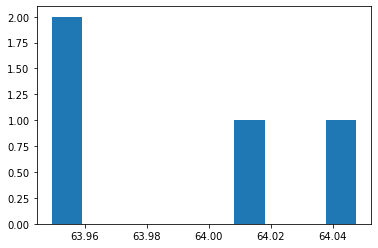

In [75]:
import matplotlib.pyplot
anchor = model(torch.tensor([0.,0.,0.,0.,0.]))
pairs = model(torch.tensor([[-1.,-1.,-1.,-1.,-1.], [1.,1.,1.,1.,1.], [-10.,-10.,-10.,-10.,-10.], [10.,10.,10.,10.,10.]]))
hammings = (128 - (anchor * pairs).sum(1))/2
print(hammings)
matplotlib.pyplot.hist(hammings.detach().numpy());

In [127]:
def deriv_triangle(d,l):
        delta = 0.49
        if (l - delta) <= d < l:
            return 1/delta
        elif l <= d <= (l + delta):
            return -1/delta
        else:
            return 0
deriv_triangle(1.4647, 2)

0